In [ ]:
# -- installation de gym
!pip install -U gymnasium pygame swig
!pip install -U moviepy==1.0.3
!pip install gymnasium[box2d]

# -- GymRecorder : enregistrer un épisode en .gif
import numpy as np
import matplotlib.pyplot as plt
import os

import gymnasium as gym
print("gym version:", gym.__version__)

from moviepy.editor import ImageSequenceClip, ipython_display

class GymRecorder(object):
    def __init__(self, env):
        self.env = env
        self._frames = []

    def record(self, frames):
        "To be called at the end of an episode."
        for frame in frames:
            self._frames.append(np.array(frame))

    def make_video(self, filename):
        "Generates the gif video."
        directory = os.path.dirname(os.path.abspath(filename))
        if not os.path.exists(directory):
            os.mkdir(directory)
        self.clip = ImageSequenceClip(list(self._frames), fps=self.env.metadata["render_fps"])
        self.clip.write_gif(filename, fps=self.env.metadata["render_fps"], loop=0)
        del self._frames
        self._frames = []

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379416 sha256=b6ec40a28d25c02b33672421bf6c3b6388df12384d73c6ecf8df2cea08239605
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
action space: Discrete(2)
MoviePy - Building file videos/CartPole-v1.gif with imageio.



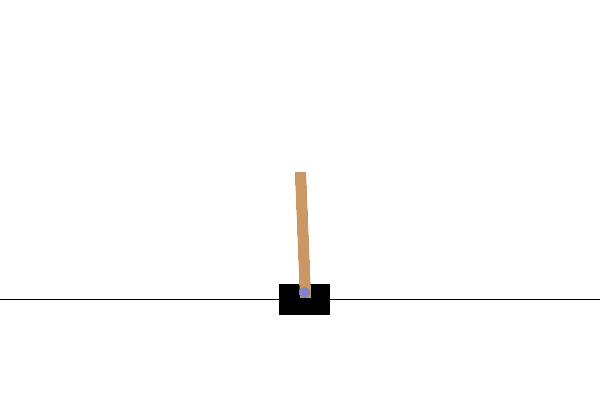

In [ ]:
# -- tester l'environnement
# --    documentation :
# --      https://gymnasium.farama.org/api/env/
# --      https://gymnasium.farama.org/environments/classic_control/cart_pole/

env = gym.make('CartPole-v1', render_mode="rgb_array_list")
recorder = GymRecorder(env)

print("observation space:", env.observation_space)
print("action space:", env.action_space)

for episode in range(10):
    state, info = env.reset()
    done = False
    while not done:
        # sélection action aléatoire
        action = env.action_space.sample()
        # appliquer l'action
        next_state, reward, terminal, truncated, info = env.step(action)
        # fin de l'épisode ?
        done = terminal or truncated

    # enregistrement de l'épisode
    recorder.record(env.render())

recorder.make_video('videos/CartPole-v1.gif')
ipython_display('videos/CartPole-v1.gif', autoplay=1, loop=0)

In [ ]:
# -- fonction de discrétisation
lower_bounds = [-4.8, -3, -0.418, -2] # for cartpole
upper_bounds = [4.8, 3, 0.418, 2]

def discretize_val(val, min_val, max_val, num_states):
    """
    Returns:
        a discrete value in [0, num_states[
    """
    state = int(num_states * (val - min_val) / (max_val - min_val))
    return np.clip(state, 0, num_states - 1)

def obs_to_state(num_states, lower_bounds, upper_bounds, obs):
	"""
	Turns an observation in R^N, into a discrete state

	Args:
	    num_states (list): list of number of states for each dimension of observation
	    lower_bounds (list): list of lowerbounds for discretization
	    upper_bounds (list): list of upperbounds for discretization
	    obs (list): observation in R^N to discretize

	Returns:
	    int: discrete state
	"""
	state_idx = []
	for ob, lower, upper, num in zip(obs, lower_bounds, upper_bounds, num_states):
		state_idx.append(discretize_val(ob, lower, upper, num))

	return np.ravel_multi_index(state_idx, num_states)

# -- test
state, _ = env.reset()
state_discrete = obs_to_state([3, 3, 3, 3], lower_bounds, upper_bounds, state)
print("état", state, "état discret", state_discrete)


état [ 0.00463686 -0.04162357 -0.03566022  0.0288258 ] état discret 40


In [ ]:
#--- apprentissage : version tabulaire

EPOCHS = 100
VERBOSE_T = 10
LEARNING_RATE = .1
EPSILON = .1
NUM_STATES = [3*2, 3*2, 3*2, 3*2] # state discretization

# -- initialisation des Q valeurs
total_states = np.prod(NUM_STATES)
total_actions = 2
Q = np.zeros((total_states, total_actions))
print("Q shape", Q.shape)

for episode in range(EPOCHS):
    obs2, _ = env.reset()
    obs2 = obs_to_state(NUM_STATES, lower_bounds, upper_bounds, obs2)
    done, sum_reward = False, 0

    # run an epidode
    episode_length = 0
    while not done:
        obs = obs2.copy()
        # action choice
        action = np.random.randint(0, total_actions)  # exploration
        # apply action
        obs2, reward, done, _, _ = env.step(action)
        obs2 = obs_to_state(NUM_STATES, lower_bounds, upper_bounds, obs2)
        sum_reward += reward
        episode_length += 1
        # Q update
        if not done:
            Q_estim = reward + GAMMA * max(Q[obs2])
        else:
            Q_estim = reward
        Q[obs, action] = LEARNING_RATE * Q_estim + (1 - LEARNING_RATE) * Q[obs, action]
    # verbose: episode infos
    if episode % VERBOSE_T == 0:
        pass # à compléter

Q shape (1296, 2)
episode 0 / 1000, rewards 8 length 8
episode 10 / 1000, rewards 9 length 9
episode 20 / 1000, rewards 9 length 9
episode 30 / 1000, rewards 15 length 15
episode 40 / 1000, rewards 14 length 14
episode 50 / 1000, rewards 32 length 32
episode 60 / 1000, rewards 9 length 9
episode 70 / 1000, rewards 11 length 11
episode 80 / 1000, rewards 14 length 14
episode 90 / 1000, rewards 39 length 39
episode 100 / 1000, rewards 10 length 10
episode 110 / 1000, rewards 9 length 9
episode 120 / 1000, rewards 13 length 13
episode 130 / 1000, rewards 59 length 59
episode 140 / 1000, rewards 9 length 9
episode 150 / 1000, rewards 13 length 13
episode 160 / 1000, rewards 36 length 36
episode 170 / 1000, rewards 32 length 32
episode 180 / 1000, rewards 9 length 9
episode 190 / 1000, rewards 30 length 30
episode 200 / 1000, rewards 35 length 35
episode 210 / 1000, rewards 11 length 11
episode 220 / 1000, rewards 8 length 8
episode 230 / 1000, rewards 9 length 9
episode 240 / 1000, rewards

In [ ]:
# -- évaluation